In [1]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from scipy.stats import norm

In [2]:
# df1= pd.read_csv('Property_Valuation_and_Assessment_Data.csv')
# df1.head()

In [3]:
df_train= pd.read_csv('data/train.csv')

In [4]:
df_test=pd.read_csv('data/test.csv')

In [5]:
print('The shape of our training set: ',df_train.shape[0], 'houses', 'and', df_train.shape[1], 'features')
print('The shape of our testing set: ',df_test.shape[0], 'houses', 'and', df_test.shape[1], 'features')
print('The testing set has 1 feature less than the training set, which is SalePrice, the target to predict  ')

The shape of our training set:  1460 houses and 81 features
The shape of our testing set:  1459 houses and 80 features
The testing set has 1 feature less than the training set, which is SalePrice, the target to predict  


#### identify categorical and numeric features

In [6]:
cat=df_train.select_dtypes(include='object')
num=df_train.select_dtypes(exclude='object')
print('We have :',cat.shape[1],'categorical features with missing values')
print('We have :',num.shape[1],'numerical features with missing values')

We have : 43 categorical features with missing values
We have : 38 numerical features with missing values


But I know some of the features that have numeric values are categorical

In [7]:
def get_categorical(df):
    #function to get catergorical varaiables from my 'numeric' dataframe because some variables are numeric but categorical
    cat_num=[]
    for i in df.columns:
        if df[i].unique().size<10:
            cat_num.append(i)
    return cat_num
get_categorical(num)



['OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'YrSold']

After careful studying of the features (through EDA ) decided that these at the features that should be categorical 
for the others are ordinal

In [8]:
df_train['MoSold'] = df_train['MoSold'].astype(str)
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['YrSold'] =df_train['YrSold'].astype(str)
# df_train['PoolArea'] =df_train['PoolArea'].astype(str)



In [9]:
df_train['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

### Data Cleaning


In [10]:
#missing data in Traing examples
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### Deal with missing values

A this point i'll idendify the columns that have 80% of its values missing (N/A)  and drop them, also take note of them for i'lll have to drop them in the test set,  aslo for some of  the columns with less than 20% of missing data i'll decide what to do on a case to case basis 

In [11]:
#function to identify and visualize the features with missing data
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3): 
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

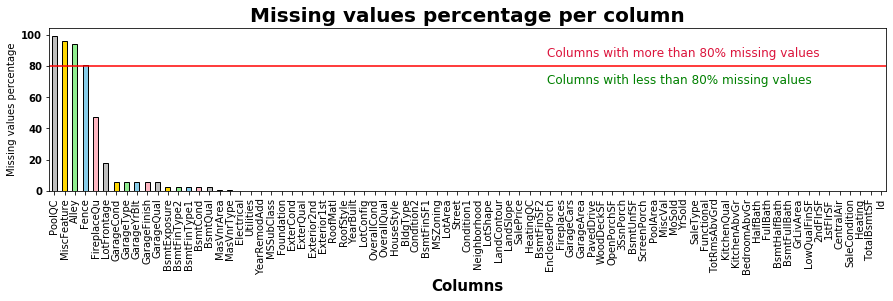

In [12]:
msv1(df_train, 80, color=('silver', 'gold', 'lightgreen', 'skyblue', 'lightpink'))


In [13]:
# drop columns (features ) with > 80% missing vales
c=df_train.dropna(thresh=len(df_train)*0.8, axis=1)
print('I dropped ',df_train.shape[1]-c.shape[1], ' features in the train set')

I dropped  5  features in the train set


In [14]:
removed=[]
for i in df_train.columns:
    if i in c.columns:
        continue
    else:
        removed.append(i) 
removed

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [15]:
allna = (c.isnull().sum() / len(c))*100
allna = allna.drop(allna[allna == 0].index).sort_values()

def msv2(data, width=12, height=8, color=('silver', 'gold','lightgreen','skyblue','lightpink'), edgecolor='black'):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    fig, ax = plt.subplots(figsize=(width, height))

    allna = (data.isnull().sum() / len(data))*100
    tightout= 0.008*max(allna)
    allna = allna.drop(allna[allna == 0].index).sort_values().reset_index()
    mn= ax.barh(allna.iloc[:,0], allna.iloc[:,1], color=color, edgecolor=edgecolor)
    ax.set_title('Missing values percentage per column', fontsize=15, weight='bold' )
    ax.set_xlabel('Percentage', weight='bold', size=15)
    ax.set_ylabel('Features ', weight='bold')
    plt.yticks(weight='bold')
    plt.xticks(weight='bold')
    for i in ax.patches:
        ax.text(i.get_width()+ tightout, i.get_y()+0.1, str(round((i.get_width()), 2))+'%',
            fontsize=10, fontweight='bold', color='grey')
    return plt.show()

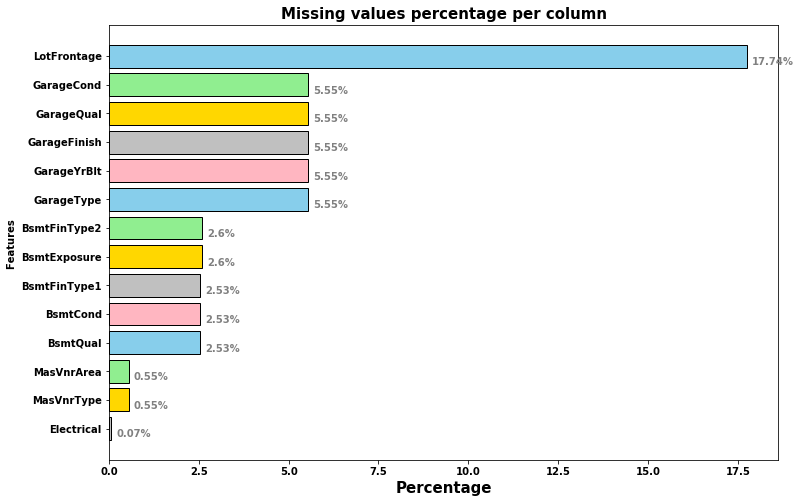

In [16]:
msv2(c)

In [17]:
#for all the NAs assign to a varriable NA
NA=c[allna.index.to_list()]

In [18]:
NAcat=NA.select_dtypes(include='object')
NAnum=NA.select_dtypes(exclude='object')
print('We have :',NAcat.shape[1],'categorical features with missing values')
print('We have :',NAnum.shape[1],'numerical features with missing values')

We have : 11 categorical features with missing values
We have : 3 numerical features with missing values


### Numerical features:

In [19]:
NAnum.head()

,MasVnrArea,GarageYrBlt,LotFrontage
0,196.0,2003.0,65.0
1,0.0,1976.0,80.0
2,162.0,2001.0,68.0
3,0.0,1998.0,60.0
4,350.0,2000.0,84.0


In [20]:
NANUM= NAnum.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

NANUM = NANUM.style.background_gradient(cmap=cm)
NANUM


,MasVnrArea,GarageYrBlt,LotFrontage
0,8,81,259


- Now i'm going to fill the missing data with median, but for LotFrontage(Linear feet of street connected to property) i'm going to fill with median according to neigbourhood

In [21]:
#MasVnrArea: Masonry veneer area in square feet, the missing data means no veneer so we fill with 0
c['MasVnrArea']=c.MasVnrArea.fillna(0)
#LotFrontage has 16% missing values. We fill with the median 
c['LotFrontage'] = c.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))
#GarageYrBlt:  Year garage was built, we fill the gaps with the median: 1980
c['GarageYrBlt']=c["GarageYrBlt"].fillna(1980)
#For the rest of the columns: Bathroom, half bathroom, basement related columns and garage related columns:
#We will fill with 0s because they just mean that the hosue doesn't have a basement, bathrooms or a garage

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

Now i check to see i have no missing numeric feaure

In [22]:
bb=c[allna.index.to_list()]
nan=bb.select_dtypes(exclude='object')
N= nan.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

N= N.style.background_gradient(cmap=cm)
N

,MasVnrArea,GarageYrBlt,LotFrontage
0,0,0,0


### Categorical features:

In [23]:
NAcat.head()

,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,SBrkr,BrkFace,Gd,TA,GLQ,No,Unf,Attchd,RFn,TA,TA
1,SBrkr,None,Gd,TA,ALQ,Gd,Unf,Attchd,RFn,TA,TA
2,SBrkr,BrkFace,Gd,TA,GLQ,Mn,Unf,Attchd,RFn,TA,TA
3,SBrkr,None,TA,Gd,ALQ,No,Unf,Detchd,Unf,TA,TA
4,SBrkr,BrkFace,Gd,TA,GLQ,Av,Unf,Attchd,RFn,TA,TA


Number of missing values per column in Categorical features after the drop missing values with > 80%

In [24]:
NAcat1= NAcat.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

NAcat1 = NAcat1.style.background_gradient(cmap=cm)
NAcat1


,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,1,8,37,37,37,38,38,81,81,81,81


we can see that we have missing data, by checking general trends of these features we can fill them with most frequent value(with mode).

In [25]:
fill_cols = ['Electrical', 'SaleType', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'Functional', 'Utilities']

for col in c[fill_cols]:
    c[col].replace(np.nan, c[col].mode()[0], inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


MSZoning part is little bit tricky I choose to fill them with most common type of the related MSSubClass type. It's not perfect but at least we decrease randomness a little bit.

In [26]:
# Filling 'MSZoning' according to MSSubClass.

c['MSZoning'] = c.groupby('MSSubClass')['MSZoning'].apply(lambda x: x.fillna(x.mode()[0]))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


for the rest of the features, i'll fill the NaN's in the columns where they mean 'None' so we gonna replace them with that

In [27]:
#we will just 'None' in categorical features
#Categorical missing values
NAcols=c.columns
for col in NAcols:
    if c[col].dtype == "object":
        c[col] = c[col].fillna("None")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [28]:
# #we will just fill 0s in the numerical features 
# #Numerical missing values
# for col in NAcols:
#     if c[col].dtype != "object":
#         c[col]= c[col].fillna(0)

In [29]:
c.isnull().sum().sort_values(ascending=False).head()

SalePrice      0
ExterCond      0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

In [30]:
FillNA=c[allna.index.to_list()]



FillNAcat=FillNA.select_dtypes(include='object')

FC= FillNAcat.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

FC= FC.style.background_gradient(cmap=cm)
FC

,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,0,0,0,0,0,0,0,0,0,0,0


,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


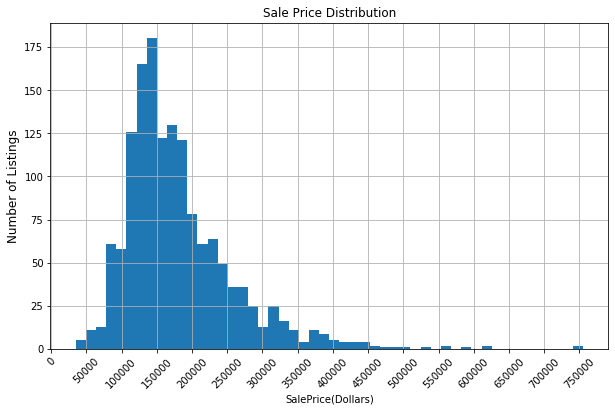

In [31]:

fig = plt.figure(figsize=(10,6))
ax = c['SalePrice'].hist(bins=50)
# ax.set_ylabel('Number of Passengers')
plt.xticks(np.arange(0,800000,50000),rotation=45,fontsize=10)
ax.set_xlabel('SalePrice(Dollars)',fontsize=10)
ax.set_ylabel('Number of Listings',fontsize=12)
ax.set_title('Sale Price Distribution',fontsize=12)
pd.DataFrame(c['SalePrice'].describe())

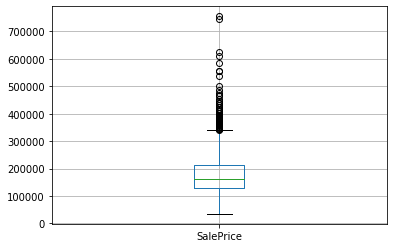

In [32]:
c.boxplot(column= 'SalePrice')


In the brief description of the whole dataset, we can see in the 1460 houses, the mean value of the sale prices is 180921 USD, while the cheapest one is only 34900 USD and the most expensive one is 757000 USD

In [33]:
# df = df.fillna(0)

### Feature Engineering

In [34]:
df=c

combined year built and year remodelled to for a new feature 

In [35]:
#true age is since when last remodel else sice when built
#df['TrueYear'] = np.where(df['YearRemodAdd'] > 0, df['YearRemodAdd'], df['YearBuilt'])
df['YearBlRm'] = (df['YearBuilt'] + df['YearRemodAdd'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
# #year since remodeled 
# df['SinceRemod'] = df['YrSold'] - df['YearRemodAdd']

##### Feature if house has a pool

In [37]:
#create feat if the house as a pool or not
df['HasPool'] = np.where(df['PoolArea'] > 0, 1, 0)
df['HasPool'] = df['HasPool'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


##### Feature if house has a basement

In [38]:
df['HasBsmt']=np.where(df['TotalBsmtSF'] > 0, 1, 0)
df['HasBsmt'] = df['HasBsmt'].astype(str)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
pd.set_option('display.max_columns', 50)

#### Total Area

I created a feature total area an addition of all the measurements of the building  and also a bathroom an addition of the bathroom feaures

In [40]:
#create feature total area an addition of all the measurements of the building 
#df['TotalArea'] =df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] +df['GarageArea']

df['TotalSF'] = (df['BsmtFinSF1'] + df['BsmtFinSF2'] +
                       df['1stFlrSF'] + df['2ndFlrSF'])

df['TotalBathrooms'] = (df['FullBath'] +
                              (0.5 * df['HalfBath']) +
                              df['BsmtFullBath'] +
                              (0.5 * df['BsmtHalfBath']))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


##### Has a garage
- createad a feature for if the house had a garage

In [41]:
df['HasGarage']=np.where(df['GarageArea'] > 0, 1, 0)
df['HasGarage'] = df['HasGarage'].astype(str)

##### Has 2nd floor
- created a feature for houses that had a second floor

In [42]:
df['Has2ndFloor']=np.where(df['2ndFlrSF'] > 0, 1, 0)
df['Has2ndFloor'] = df['Has2ndFloor'].astype(str)

##### Has a porch
- created a feature for houses with a porch

first grouped all the types of porches

In [43]:
#summed up all the measurement of porches
df['TotalPorchSF'] = (df['OpenPorchSF'] + df['3SsnPorch'] +
                            df['EnclosedPorch'] +
                            df['ScreenPorch'] + df['WoodDeckSF'])


In [44]:
df['HasPorch']=np.where(df['TotalPorchSF'] > 0, 1, 0)
df['HasPorch'] = df['HasPorch'].astype(str)

In [45]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,YearBlRm,HasPool,HasBsmt,TotalSF,TotalBathrooms,HasGarage,Has2ndFloor,TotalPorchSF,HasPorch
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,4006,0,1,2416,3.5,1,1,61,1
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,...,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,3952,0,1,2240,2.5,1,0,298,1
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,4003,0,1,2272,3.5,1,1,42,1
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,...,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,3885,0,1,1933,2.0,1,1,307,1
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,4000,0,1,2853,3.5,1,1,276,1


In [46]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.790982
GrLivArea         0.708624
TotalSF           0.708047
GarageCars        0.640409
TotalBathrooms    0.631731
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBlRm          0.576144
FullBath          0.560664
TotRmsAbvGrd      0.533723
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
Fireplaces        0.466929
GarageYrBlt       0.466754
TotalPorchSF      0.390993
BsmtFinSF1        0.386420
LotFrontage       0.349876
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
Id               -0.021917
LowQualFinSF     -0.025606
OverallCond      -0.077856
E

Text(0.5, 1, 'Column pairs with correlation coefficient higher than 0.7')

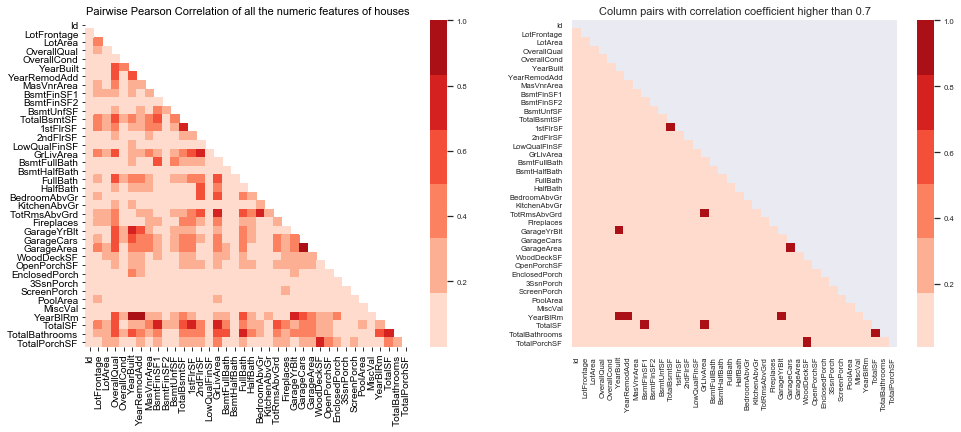

In [47]:
#drop target varribale

df_no_SP = df.drop('SalePrice',axis=1)
corr_all = abs(df_no_SP.corr())


# Thresholding the correlations larger than 0.7 (or-0.7) 
corr_all_true = corr_all>0.7 
corr_all_true = corr_all_true

corr_dict = {}
for column in corr_all_true:
    corr_list = corr_all_true[column][corr_all_true[column]==True].index.tolist()
    corr_dict[column] = corr_list

# pprint.pprint(corr_dict)

# create custom color map
cmap = sns.color_palette("Reds")
fig1 = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
# Generate a mask for the upper triangle
sns.set(font_scale=0.7)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, mask=mask, cmap=cmap,
          xticklabels=corr_all.columns.values,
          yticklabels=corr_all.columns.values)
plt.title('Pairwise Pearson Correlation of all the numeric features of houses',fontsize=11)


# fig2 = plt.figure()
plt.subplot(1,2,2)
sns.heatmap(corr_all_true,mask=mask,cmap=cmap,
           xticklabels=corr_all_true.columns.values,
           yticklabels=corr_all_true.columns.values,
           vmin=0.01,vmax=1)

plt.title('Column pairs with correlation coefficient higher than 0.7',fontsize=11)

In [48]:

# Build a list of all the numeric column names for our dataframe, except SalePrice
num_cols_all = list(corr_all.columns)
# print(cols)
cols = num_cols_all

# See how many columns there are at first
len_1=len(num_cols_all)
removed_features=[]
# In the correlation dictionary, if the key is still in the columns_list, remove the items in the value from the columns_list that is not equal
# to the key itself.
for key, value in corr_dict.items():
    if key in cols:
        for feature in value:
            if (feature in cols) & (feature != key and feature != 'TrueYear'):#keep True age
                cols.remove(feature)
                removed_features.append(feature)
# Take a look how many features (columns) are removed from the last step.
len_2 = len(cols)

df = df.drop(removed_features,axis=1)
print('There are',len(removed_features),'features removed for high pairwise correlation:\n\n',removed_features)

There are 7 features removed for high pairwise correlation:

 ['GarageYrBlt', 'YearBlRm', 'TotalSF', '1stFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'TotalPorchSF']


#### Run pairwise pearson correlation plot to confirm we have removed all the features with high pair-correlation


Text(0.5, 1, 'Pairwise Pearson Correlation of Remaining Numeric Features of Houses')

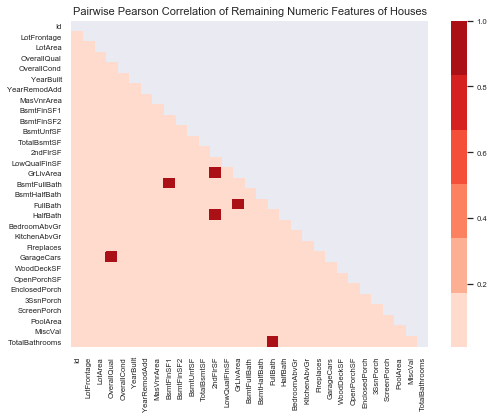

In [49]:

# select the dependent columns from previous DataFrame with no SalePrice, calculate the cross correlation, setup same threshold
# as before, and plot the heat map for the ture-false map. 
corr_no_repeat = abs(df[cols].corr())>0.6
# corr_no_repeat = abs(df[cols].corr())
fig3 = plt.figure(figsize=(8,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
cmap = sns.color_palette("Reds")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_no_repeat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_no_repeat, mask=mask,cmap=cmap,
          xticklabels=corr_no_repeat.columns.values,
          yticklabels=corr_no_repeat.columns.values,
          vmin=0.01,vmax=1)
sns.set(font_scale=1.3)
plt.title('Pairwise Pearson Correlation of Remaining Numeric Features of Houses',fontsize=11)

#### Study the correlation between the top related numerical features and SalePrice

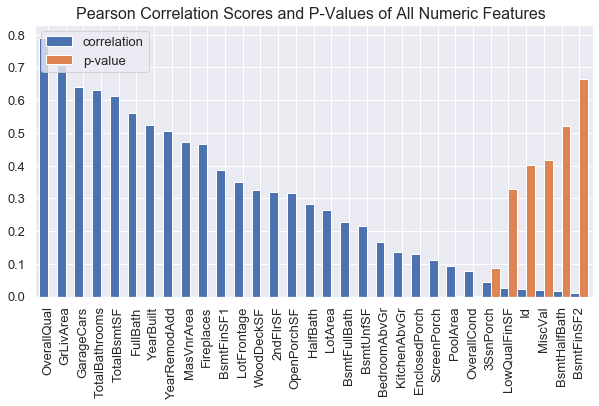

In [50]:

# Rebuild the numeric dataframe with SalePrice
num_cols = cols
num_df = df[num_cols]

pearson_dict={}
for col in num_df.columns:
    pearson_dict[col] = stats.pearsonr(df[col], df['SalePrice'])
# pprint.pprint(pear_dict)
pearson_df = pd.DataFrame(pearson_dict,index=['correlation','p-value'])
pearson_df=pearson_df.T.abs().sort_values(['correlation','p-value'],ascending=[False,True])
pearson_df.plot.bar(figsize=(10,5),fontsize=13,width=1)
plt.title('Pearson Correlation Scores and P-Values of All Numeric Features ',fontsize=16)
plt.legend(fontsize=13,loc = 2)

 #### The plot  above shows the correlation coefficients of features VS saleprice, from high to low for all the features.
And the p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets, which means the lower p-value is, the better correlation is.



In [51]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.790982
GrLivArea         0.708624
GarageCars        0.640409
TotalBathrooms    0.631731
TotalBsmtSF       0.613581
FullBath          0.560664
YearBuilt         0.522897
YearRemodAdd      0.507101
MasVnrArea        0.472614
Fireplaces        0.466929
BsmtFinSF1        0.386420
LotFrontage       0.349876
WoodDeckSF        0.324413
2ndFlrSF          0.319334
OpenPorchSF       0.315856
HalfBath          0.284108
LotArea           0.263843
BsmtFullBath      0.227122
BsmtUnfSF         0.214479
BedroomAbvGr      0.168213
ScreenPorch       0.111447
PoolArea          0.092404
3SsnPorch         0.044584
BsmtFinSF2       -0.011378
BsmtHalfBath     -0.016844
MiscVal          -0.021190
Id               -0.021917
LowQualFinSF     -0.025606
OverallCond      -0.077856
EnclosedPorch    -0.128578
KitchenAbvGr     -0.135907
dtype: float64

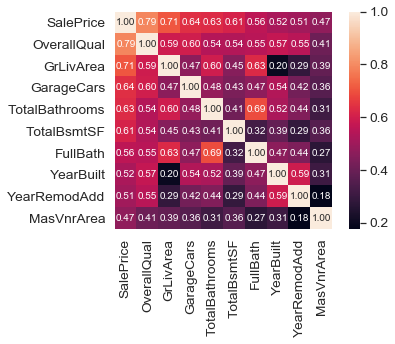

In [52]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

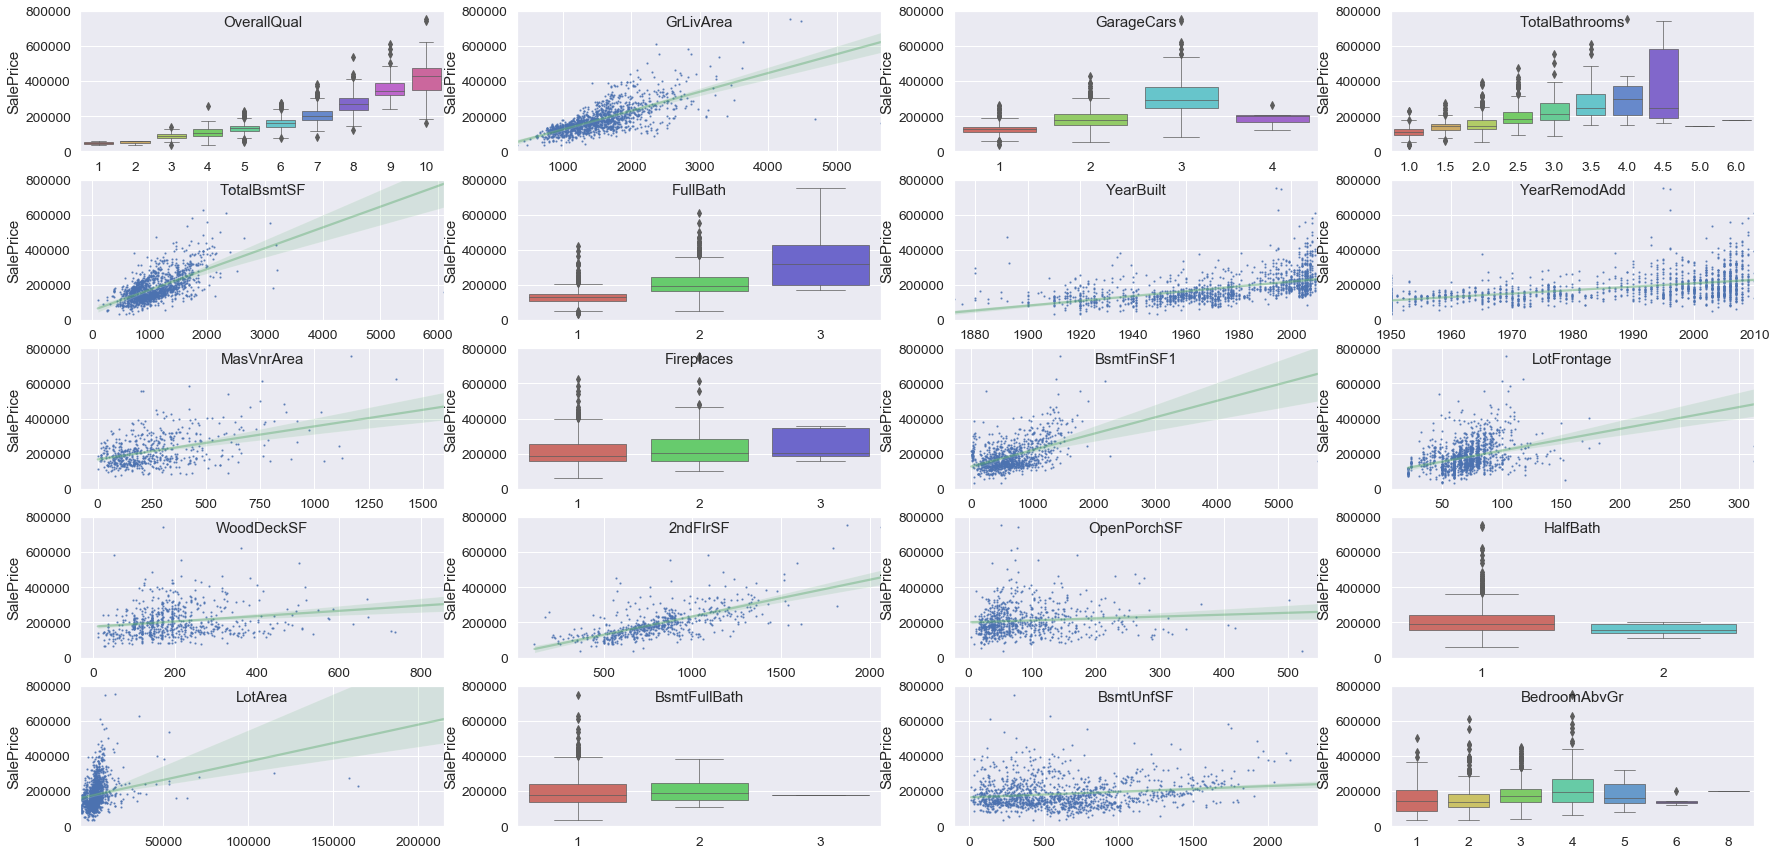

In [53]:

plt.fontsize=5
plt.figure(figsize=(30,15))
for i in range(20):
    name = pearson_df.index[i]
    plt.subplot(5,4,i+1)
    plt.ylim(0,800000)
    if df[name].unique().size>20:# nummeric features have more range
        sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
    else:
#         sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4},x_estimator=np.mean)
        sns.boxplot(x=name, y='SalePrice',data=df[df[name]>0],palette='hls',linewidth=0.7)
    plt.title(name,y=0.85)
    plt.savefig('pair.png', bbox_inches='tight');
    plt.xlabel('')
  


### A closer look at some of the numeric features

- GarageArea (Size of garage in square feet)
- TotalBsmtSF (Total square feet of basement area)
- YearBuilt ( Original Constrbbuction Data)
- TrueYear (Engineered Feature)

#### GrLivArea (Size of garage in square feet)

Text(0.5, 0, 'Above grade (ground) living area square feet')

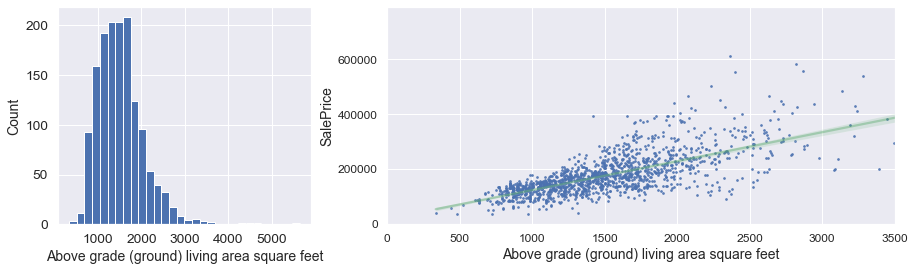

In [54]:
from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['GrLivArea'],bins=30)
plt.xlabel('Above grade (ground) living area square feet',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])

sns.regplot(x='GrLivArea', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,3500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Above grade (ground) living area square feet',fontsize=14)




The histogram above shows the distribution of the GrLivArea. And the scatter plot with regression line shows that there is clear correlation between GrLivArea and SalePrice.

In [55]:
# df['log_GrLivArea']= (df['GrLivArea']).apply(lambda x:np.log(x))
# fig4, ax = plt.subplots(figsize=(5,5)) 
    
# sns.scatterplot(data=df, y=df['SalePrice'], x=df['log_GrLivArea'])

####  TotalBsmtSF (Total square feet of basement area)

Text(0.5, 0, 'Total square feet of basement area')

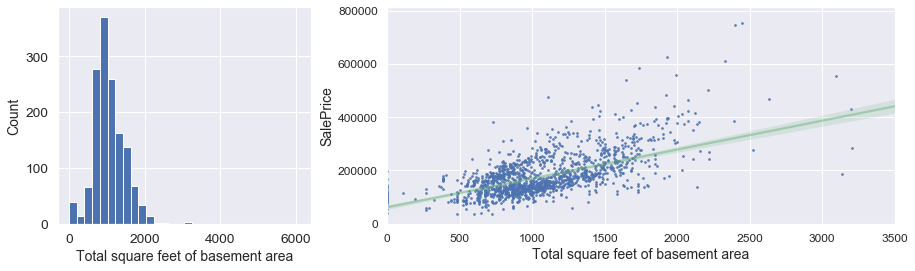

In [56]:

from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['TotalBsmtSF'],bins=30)
plt.xlabel('Total square feet of basement area',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])

sns.regplot(x='TotalBsmtSF', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,3500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Total square feet of basement area',fontsize=14)

The histogram above shows the distribution of the TotalBsmtSF. And the scatter plot with regression line shows that there is clear correlation between TotalBsmtSF and SalePrice.

#### YearBuilt (Original Construction Data)

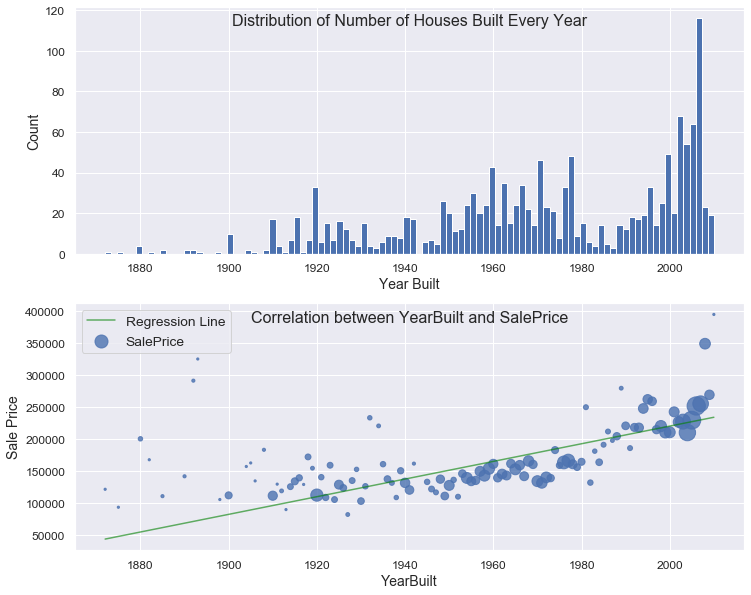

In [57]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.YearBuilt,bins=100)
YearMean=df.groupby(['YearBuilt']).SalePrice.mean()
YearSize=df.groupby(['YearBuilt']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Year Built',fontsize=14)
plt.title('Distribution of Number of Houses Built Every Year',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)

fit = np.polyfit(df.YearBuilt,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('YearBuilt',fontsize=14)
plt.title('Correlation between YearBuilt and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])

There seems to be a general linear relationship between Year built and Sale price, but some what might seem to be old building are still going for above average


#### YearRemodAdd

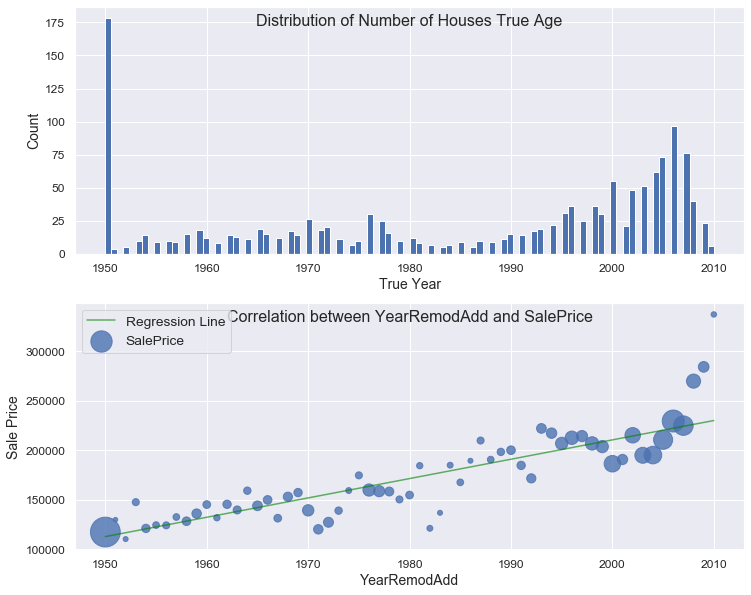

In [58]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.YearRemodAdd,bins=100)
YearMean=df.groupby(['YearRemodAdd']).SalePrice.mean()
YearSize=df.groupby(['YearRemodAdd']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('True Year',fontsize=14)
plt.title('Distribution of Number of Houses True Age',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)
# the regression line is created with all the original SalePrice, not the year-mean value
fit = np.polyfit(df.YearRemodAdd,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('YearRemodAdd',fontsize=14)
plt.title('Correlation between YearRemodAdd and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])
plt.savefig('yearvsale.png', bbox_inches='tight');

There is more of a linear relationship between YearRemodAdd and SalesPrice which is expected.Because accounting for rennovation in the houses would explain why some old houses still went for high prices

In [59]:
lm= ['January','February','March','April','May','June','July','August','September','October','November','December']

Text(0.5, 0.9, 'Distribution of Number of Houses sales across months')

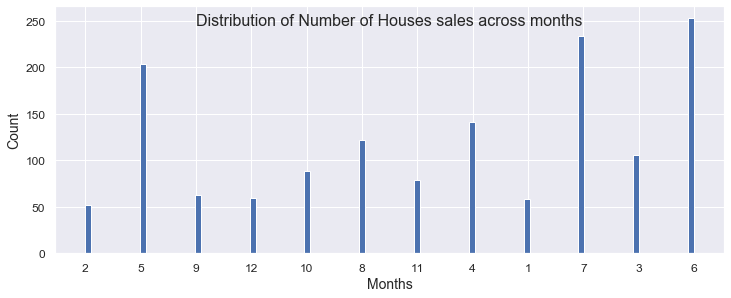

In [60]:
fig1= plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.MoSold,bins=100)
month=df.groupby(['MoSold']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
#plt.xticks( [ 1,2 , 3, 4,5,6,7,8,9,10,11,12],lm, rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Distribution of Number of Houses sales across months',fontsize=16,y=0.9)


June and july over the years seem to be the highest selling months

### Correlation between the categorical features and SalePrice

- prepare the categorical features
- rate the correlations of each features VS SalePrice and save in DataFrame
- Sort the features by r_2 scores from high to low. Show the result in a table and a barplot below.

In [61]:
len(num_cols)

31

In [62]:
from statsmodels.formula.api import ols

############### prepare categorical features#################### 
# cat_df: categorical data from original df
cat_df = df.drop(num_cols,axis=1).drop('SalePrice',axis=1)

############### Rate the correlation with R_2 sccore############
features_R = {}
for feature in cat_df.columns.values.tolist():
    model = ols('SalePrice ~'+feature, df).fit()
    features_R[feature] = model.rsquared

############### Sort the features by r_2 scores ################
r_df = pd.DataFrame(list(features_R.items()),columns=['features','R_squared']).sort_values(by=['R_squared'],ascending=False)
r_df.index = r_df['features']
r_df = r_df.drop('features',axis=1)

In [63]:

r_df.T

features,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,Foundation,GarageType,MSSubClass,BsmtFinType1,HeatingQC,MasVnrType,Exterior2nd,Exterior1st,BsmtExposure,SaleType,SaleCondition,MSZoning,HouseStyle,GarageQual,GarageCond,LotShape,HasPorch,CentralAir,Electrical,RoofStyle,HasGarage,PavedDrive,BsmtCond,BldgType,Condition1,RoofMatl,BsmtFinType2,LandContour,ExterCond,HasBsmt,LotConfig,Has2ndFloor,Functional,Heating,Condition2,HasPool,MoSold,LandSlope,YrSold,Street,Utilities
R_squared,0.545575,0.477388,0.464994,0.456599,0.305874,0.256368,0.249204,0.246316,0.21081,0.1955,0.183277,0.15383,0.152773,0.1495,0.137287,0.135497,0.10756,0.086313,0.081421,0.081346,0.076376,0.067431,0.063166,0.059651,0.057697,0.056089,0.05454,0.051396,0.034534,0.032631,0.031413,0.030294,0.025794,0.023618,0.023357,0.021019,0.018949,0.01648,0.014437,0.009899,0.008781,0.007224,0.002682,0.001771,0.001684,0.000205


<Figure size 936x576 with 0 Axes>

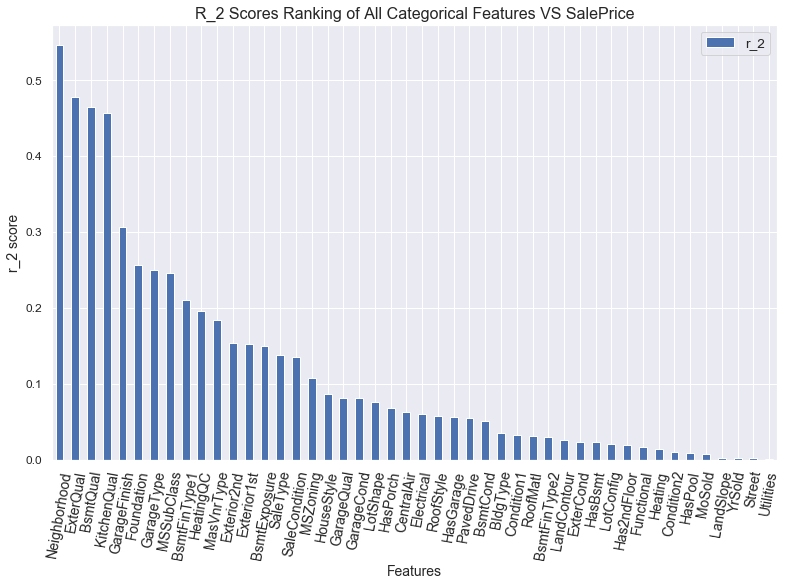

In [64]:
fig = plt.figure(figsize=(13,8))
# plt.bar(r_df.index,r_df.R_squared)
r_df.plot.bar(figsize=(13,8))
plt.title('R_2 Scores Ranking of All Categorical Features VS SalePrice',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(rotation=80,fontsize=14)
plt.ylabel('r_2 score',fontsize=14)
plt.xlabel('Features',fontsize=14)
plt.legend(['r_2'])
plt.savefig('R_cat.png', bbox_inches='tight');

#### Take a closer look at some top ranked features

- MSSubClass(Building Class)
- Neighborhood(Physical locations within Ames city limits)
- ExterQual( Exterior material quality)
- BsmtQual(Evaluates the height of the basement)

Text(0.5, 0.98, '')

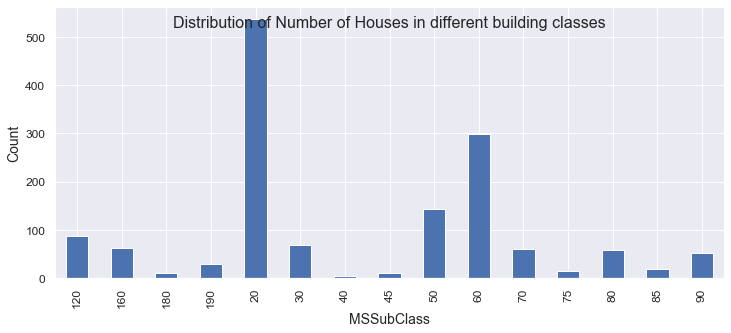

<Figure size 864x360 with 0 Axes>

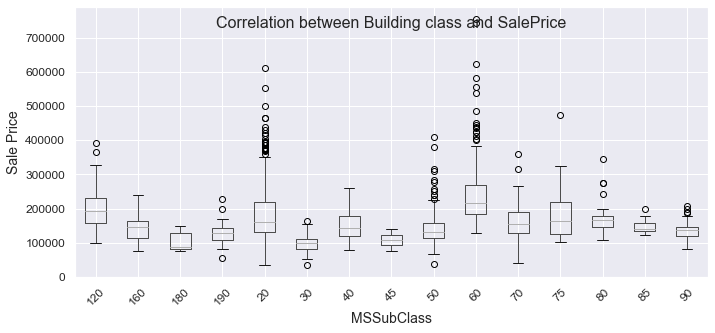

In [73]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('MSSubClass').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('MSSubClass',fontsize=14)
plt.title('Distribution of Number of Houses in different building classes',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='MSSubClass',figsize=(11,5),rot=45)
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('MSSubClass',fontsize=14)
plt.title('Correlation between Building class and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

 20: 1-STORY 1946 & NEWER ALL STYLES seem to be the more frequently present building class and also has the most range although,  60 :2-STORY 1946 & NEWER has the highest mean, which agrees with logic

Text(0.5, 0.98, '')

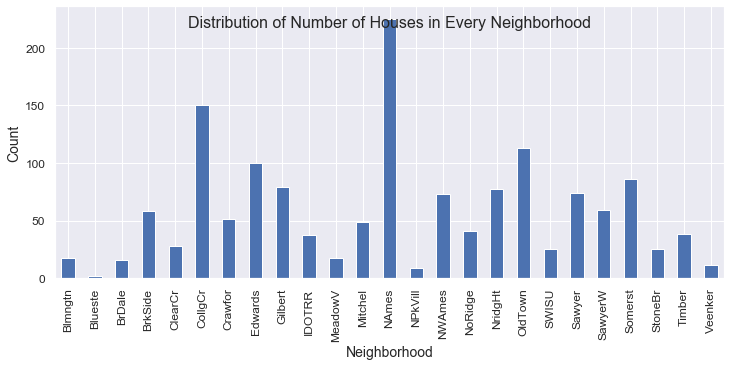

<Figure size 864x360 with 0 Axes>

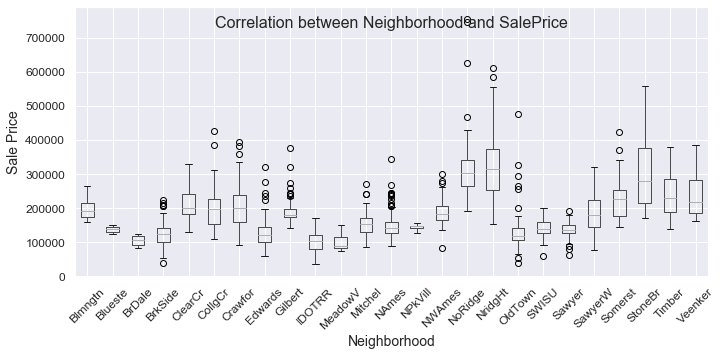

In [65]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('Neighborhood').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Distribution of Number of Houses in Every Neighborhood',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='Neighborhood',figsize=(11,5),rot=45)
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Correlation between Neighborhood and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

Text(0.5, 0.98, '')

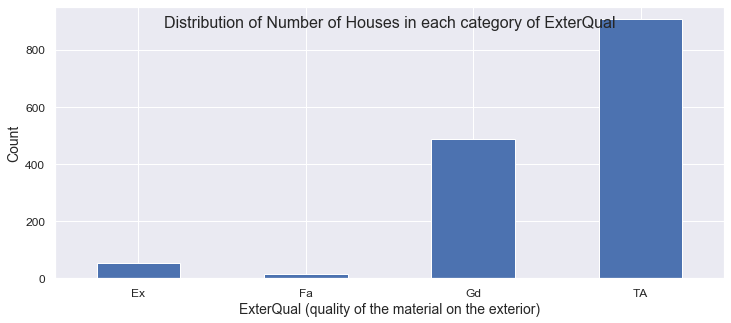

<Figure size 864x360 with 0 Axes>

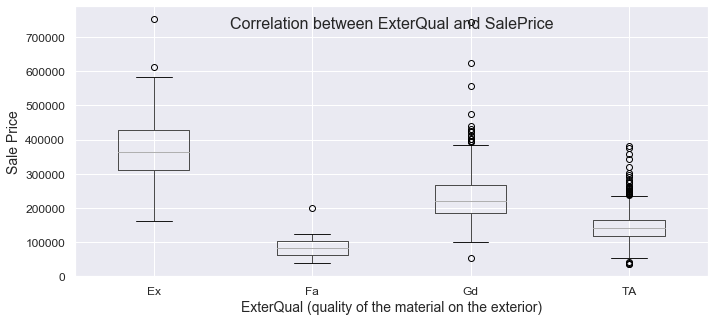

In [66]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('ExterQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of ExterQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='ExterQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Correlation between ExterQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

From the plots above, when it came to Fa (fair) quality of material on the exterior it seems to be compromisable

#### BsmtQual:

Text(0.5, 0.98, '')

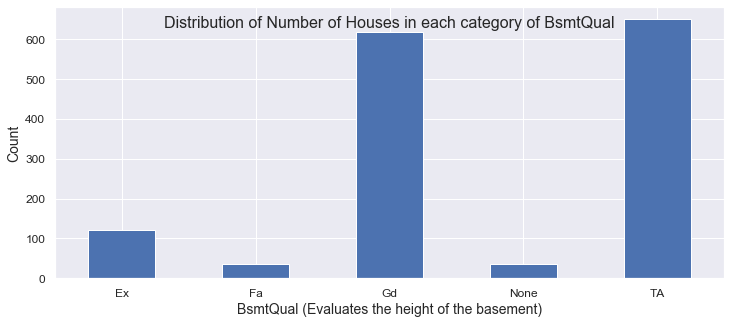

<Figure size 864x360 with 0 Axes>

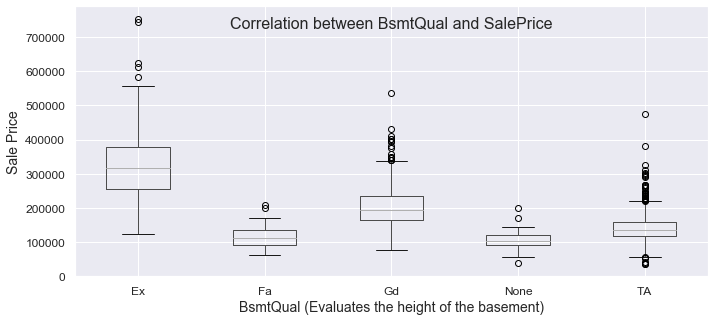

In [67]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('BsmtQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of BsmtQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='BsmtQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Correlation between BsmtQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

From the plots above, it is obvious that houses in some BsmtQual have higher price, and some have lower price.

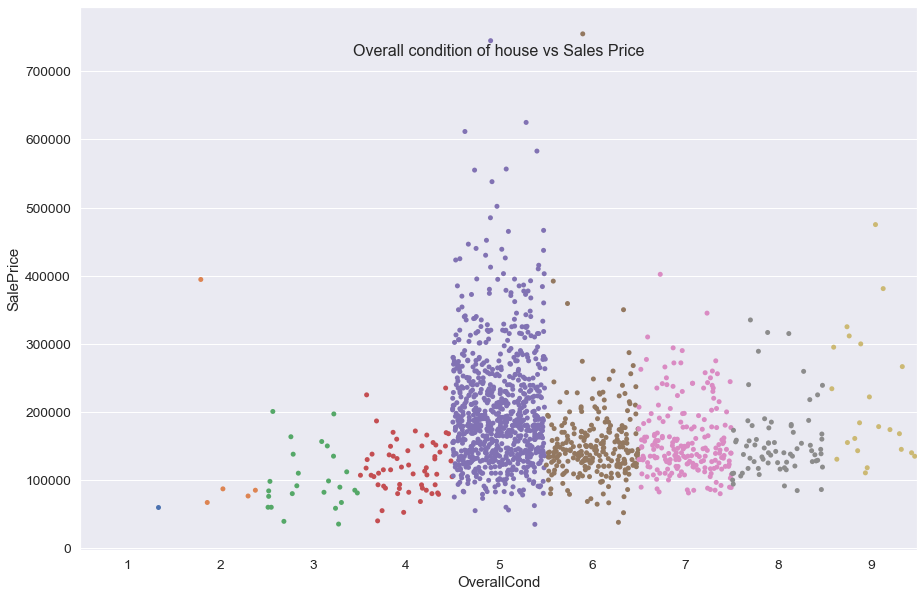

In [68]:

f, ax = plt.subplots(figsize=(15, 10))
sns.stripplot(data = df_train, x='OverallCond', y='SalePrice', jitter=.5)
plt.title('Overall condition of house vs Sales Price',fontsize=16,y=0.9)
plt.savefig('overall.png', bbox_inches='tight');
plt.show()

#### Convert categorical data to numeric

After exploring and inspecting some of my categorical features in the iterative process, I'm going to convert some of these categories to numerical ones, especially the ones where related to quality of the specific features

In [70]:
# Converting some of the categorical values to numeric ones.

neigh_map = {
    'MeadowV': 1,
    'IDOTRR': 1,
    'BrDale': 1,
    'BrkSide': 2,
    'OldTown': 2,
    'Edwards': 2,
    'Sawyer': 3,
    'Blueste': 3,
    'SWISU': 3,
    'NPkVill': 3,
    'NAmes': 3,
    'Mitchel': 4,
    'SawyerW': 5,
    'NWAmes': 5,
    'Gilbert': 5,
    'Blmngtn': 5,
    'CollgCr': 5,
    'ClearCr': 6,
    'Crawfor': 6,
    'Veenker': 7,
    'Somerst': 7,
    'Timber': 8,
    'StoneBr': 9,
    'NridgHt': 10,
    'NoRidge': 10
}
df['Neighborhood_rate'] = df['Neighborhood'].map(neigh_map).astype('int')
ext_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['ExterQual'] = df['ExterQual'].map(ext_map).astype('int')
df['ExterCond'] = df['ExterCond'].map(ext_map).astype('int')
bsm_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['BsmtQual'] = df['BsmtQual'].map(bsm_map).astype('int')
df['BsmtCond'] = df['BsmtCond'].map(bsm_map).astype('int')
bsmf_map = {
    'None': 0,
    'Unf': 1,
    'LwQ': 2,
    'Rec': 3,
    'BLQ': 4,
    'ALQ': 5,
    'GLQ': 6
}
df['BsmtFinType1'] = df['BsmtFinType1'].map(bsmf_map).astype('int')
df['BsmtFinType2'] = df['BsmtFinType2'].map(bsmf_map).astype('int')
heat_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['HeatingQC'] = df['HeatingQC'].map(heat_map).astype('int')
df['KitchenQual'] = df['KitchenQual'].map(heat_map).astype('int')
#df['FireplaceQu'] = df['FireplaceQu'].map(bsm_map).astype('int')
df['GarageCond'] = df['GarageCond'].map(bsm_map).astype('int')
df['GarageQual'] = df['GarageQual'].map(bsm_map).astype('int')

#### Again we take a look at the correlation now we have a set of new features

###### for numeric features

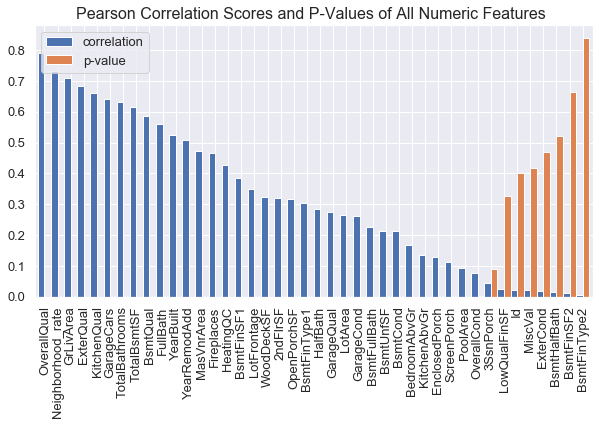

In [75]:
#drop SalePrice
df_no_SP = df.drop('SalePrice',axis=1)
corr_all = abs(df_no_SP.corr())


# Build a list of all the numeric column names for our dataframe, except SalePrice
num_cols = list(corr_all.columns)
# print(cols)
num_df = df[num_cols]

pearson_dict={}
for col in num_df.columns:
    pearson_dict[col] = stats.pearsonr(df[col], df['SalePrice'])
# pprint.pprint(pear_dict)
pearson_df = pd.DataFrame(pearson_dict,index=['correlation','p-value'])
pearson_df=pearson_df.T.abs().sort_values(['correlation','p-value'],ascending=[False,True])
pearson_df.plot.bar(figsize=(10,5),fontsize=13,width=1)
plt.title('Pearson Correlation Scores and P-Values of All Numeric Features ',fontsize=16)
plt.legend(fontsize=13,loc = 2)

##### for categorical features


In [91]:
############### prepare categorical features#################### 
# cat_df: categorical data from original df
cat_df = df.drop(num_cols,axis=1).drop('SalePrice',axis=1)

############### Rate the correlation with R_2 sccore############
features_R = {}
for feature in cat_df.columns.values.tolist():
    model = ols('SalePrice ~'+feature, df).fit()
    features_R[feature] = model.rsquared

############### Sort the features by r_2 scores ################
r_df = pd.DataFrame(list(features_R.items()),columns=['features','R_squared']).sort_values(by=['R_squared'],ascending=False)
r_df.index = r_df['features']
r_df = r_df.drop('features',axis=1)

In [92]:
r_df.T

features,Neighborhood,GarageFinish,GarageType,MSSubClass,Foundation,MasVnrType,Exterior1st,MSZoning,Exterior2nd,BsmtExposure,SaleCondition,CentralAir,SaleType,HasGarage,HouseStyle,Electrical,PavedDrive,HasPorch,LotShape,RoofStyle,Condition1,BldgType,HasBsmt,Heating,LandContour,Functional,LotConfig,Has2ndFloor,RoofMatl,Condition2,MoSold,HasPool,Street,YrSold,LandSlope,Utilities
R_squared,0.570808,0.381034,0.334639,0.330127,0.303651,0.188145,0.181531,0.175839,0.171463,0.142594,0.12902,0.123623,0.120115,0.104328,0.102097,0.096518,0.093227,0.092575,0.087826,0.043098,0.042434,0.04014,0.039854,0.032946,0.025632,0.023789,0.023339,0.022665,0.0179,0.012039,0.007493,0.004877,0.003291,0.002026,0.001484,0.00016


### High correlated features:

Considering correlation(or r_squared)>0.05 as significant, the top numerical features and top categorical features are listed below, and we are going to use these useful_features for the following model training.

In [93]:
# absolute values >0.05
num_top_features = pearson_df[abs(pearson_df['correlation'])>0.05].index.values.tolist()
cat_top_features = r_df[abs(r_df['R_squared'])>0.05].index.values.tolist()
useful_features = num_top_features+cat_top_features
print(len(num_top_features),'numerical features:\n',num_top_features,'\n')
print(len(cat_top_features),'categorical features:\n',cat_top_features)

34 numerical features:
 ['OverallQual', 'Neighborhood_rate', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'TotalBathrooms', 'TotalBsmtSF', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'HeatingQC', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtFinType1', 'HalfBath', 'GarageQual', 'LotArea', 'GarageCond', 'BsmtFullBath', 'BsmtUnfSF', 'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'OverallCond'] 

19 categorical features:
 ['Neighborhood', 'GarageFinish', 'GarageType', 'MSSubClass', 'Foundation', 'MasVnrType', 'Exterior1st', 'MSZoning', 'Exterior2nd', 'BsmtExposure', 'SaleCondition', 'CentralAir', 'SaleType', 'HasGarage', 'HouseStyle', 'Electrical', 'PavedDrive', 'HasPorch', 'LotShape']


### A closer look at the target variable (SalePrice)

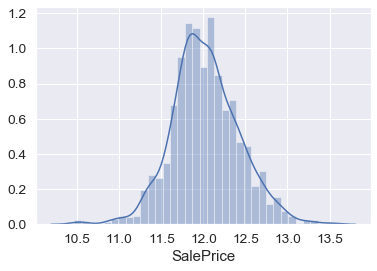

In [94]:
# Histogram
sns.distplot(df.SalePrice);

In [95]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


- SalePrice is not normal distributed
- Have positive skewness

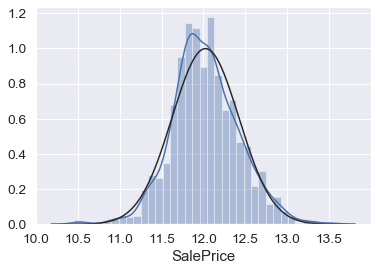

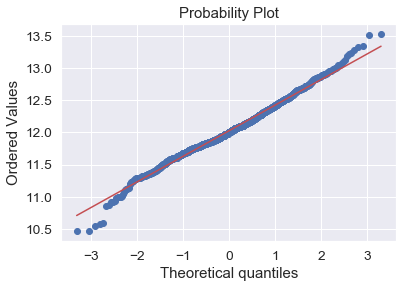

In [96]:
#histogram and normal probability plot
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)


As seen above, 'SalePrice' is not normally distributed. We can solve this with simple log transformation.



In [97]:
#log transform saleprice
df.SalePrice = np.log(df.SalePrice)

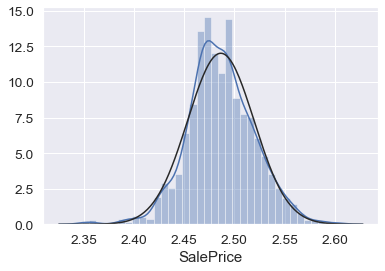

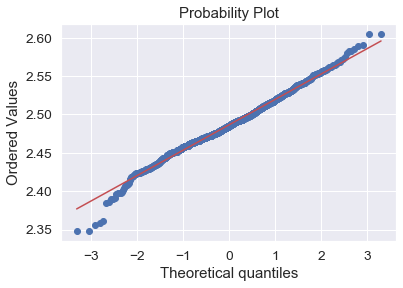

In [98]:
# histogram and normal probability plot
sns.distplot(df.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(df.SalePrice, plot=plt)

In [99]:
len(df[useful_features].columns)

53

### Encoding categorical variables

I have established that 53 of my features are useful after the EDA, 19 categorical and 34 numeric stored in varaibale useful_features

In [100]:
print(useful_features)

['OverallQual', 'Neighborhood_rate', 'GrLivArea', 'ExterQual', 'KitchenQual', 'GarageCars', 'TotalBathrooms', 'TotalBsmtSF', 'BsmtQual', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'Fireplaces', 'HeatingQC', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'BsmtFinType1', 'HalfBath', 'GarageQual', 'LotArea', 'GarageCond', 'BsmtFullBath', 'BsmtUnfSF', 'BsmtCond', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'OverallCond', 'Neighborhood', 'GarageFinish', 'GarageType', 'MSSubClass', 'Foundation', 'MasVnrType', 'Exterior1st', 'MSZoning', 'Exterior2nd', 'BsmtExposure', 'SaleCondition', 'CentralAir', 'SaleType', 'HasGarage', 'HouseStyle', 'Electrical', 'PavedDrive', 'HasPorch', 'LotShape']


In [101]:
# get datafram of useful feat in df2
df2=df[useful_features]

In [102]:
cat2=df2.select_dtypes(include='object')
num2=df2.select_dtypes(exclude='object')
print('We have :',cat2.shape[1],'categorical features')
print('We have :',num2.shape[1],'numerical features ')

We have : 19 categorical features
We have : 34 numerical features 


### One hot encoding

In [103]:
df3=pd.get_dummies(df2)

In [104]:

print("the shape of the original dataset",df2.shape)
print("the shape of the encoded dataset",df3.shape)
print("We have ",df3.shape[1]- df2.shape[1], 'new encoded features')

the shape of the original dataset (1460, 53)
the shape of the encoded dataset (1460, 177)
We have  124 new encoded features


## MODELING

In [105]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.simplefilter(action='ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import math
import sklearn.model_selection as ms
import sklearn.metrics as sklm
from sklearn.model_selection import train_test_split

###### Target with log transformation

In [106]:
#target with log transformation
target=df[['SalePrice']]

##### Target without log trasformation

In [107]:
#target without log transfomation
target2=df_train[['SalePrice']]

In [ ]:
#assign target and feature variables
y =np.array(target2)
X=df3

In [ ]:
X2=df_train.drop(columns='SalePrice', axis= 1)
y2= df_train['SalePrice']

In [ ]:
print(X.shape)   
print(y.shape) 

##### split them to train and test sets

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=22,test_size=0.2)

Baseline OLS


In [ ]:
# from sklearn.preprocessing import StandardScaler
# #transform to scalar

# scaler2 = StandardScaler()
# # fit the scaler to the training data
# scaler2.fit(X_train)

# #transform the training data
# X_train = pd.DataFrame(data=scaler2.transform(X_train), columns=df_train.columns)

# #transform the testing dat
# X_test = pd.DataFrame(data=scaler2.transform(X_test), columns=df_train.columns)

In [ ]:
# import statsmodels.api as sm
# from statsmodels.formula.api import ols

# X2= sm.add_constant(X_train)
# Y2= y_train.values.reshape(-1,1)##if your frame is not lining up use
# lr_model=sm.OLS(Y2,X2).fit()
# lr_model.summary()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y,test_size = .3, random_state=0)

##### I use RobustScaler to scale our data because it's powerful against outliers

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler= RobustScaler()
# transform "x_train"
x_train = scaler.fit_transform(x_train)
# transform "x_test"
x_test = scaler.transform(x_test)

# #Transform the test set
# X_test= scaler.transform(Test)

### Linear regression

In [ ]:
from sklearn.linear_model import LinearRegression

lreg=LinearRegression()
MSEs=ms.cross_val_score(lreg,X , y, scoring='neg_mean_squared_error', cv=5)
meanMSE=np.mean(MSEs)
print(meanMSE)
print('RMSE = '+str(math.sqrt(-meanMSE)))
# print(f'The RMSE: {np.sqrt(mean_squared_error(np.expm1(y_teste),np.expm1(reg_pred)))}')

### Ridge and lasso regression

#### Ridge regression:

In [ ]:
import sklearn.model_selection as GridSearchCV # to get more great Hypert pramater value
from sklearn.linear_model import Ridge

ridge=Ridge()
parameters= {'alpha':[x for x in range(1,101)]}

ridge_reg=ms.GridSearchCV(ridge, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
ridge_reg.fit(x_train,y_train)
print("The best value of Alpha is: ",ridge_reg.best_params_)
# print("The best score achieved with Alpha=9 is: ",math.sqrt(-ridge_reg.best_score_))
# ridge_pred=math.sqrt(-ridge_reg.best_score_)

In [ ]:
ridge_mod=Ridge(alpha=12)
ridge_mod.fit(x_train,y_train)
y_pred_train=ridge_mod.predict(x_train)
y_pred_test=ridge_mod.predict(x_test)

print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_pred_train))))
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_pred_test))))  
#print(f'The RMSE: {np.sqrt(mean_squared_error(np.expm1(y_test),np.expm1(y_pred_test)))}')

In [ ]:
s_d=np.std(df_train['SalePrice'])
RMsee=(math.sqrt(sklm.mean_squared_error(y_test, y_pred_test)))
RMsee/s_d                 

#### Lasso Regression

In [ ]:
from sklearn.linear_model import Lasso

parameters= {'alpha':[0.0001,0.0009,0.001,0.002,0.003,0.01,0.1,1,10,100,200,500]}


lasso=Lasso()
lasso_reg=ms.GridSearchCV(lasso, param_grid=parameters, scoring='neg_mean_squared_error', cv=15)
lasso_reg.fit(x_train,y_train)

print('The best value of Alpha is: ',lasso_reg.best_params_)

In [ ]:
lasso_mod=Lasso(alpha=100)
lasso_mod.fit(x_train,y_train)
y_lasso_train=lasso_mod.predict(x_train)
y_lasso_test=lasso_mod.predict(x_test)

print('Root Mean Square Error train = ' + str(math.sqrt(sklm.mean_squared_error(y_train, y_lasso_train))))
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, y_lasso_test))))

In [ ]:
coefs = pd.Series(lasso_mod.coef_, index = X.columns)

imp_coefs = pd.concat([coefs.sort_values().head(15),
                     coefs.sort_values().tail(15)])
fig5 =imp_coefs.plot(kind = "barh", color='yellowgreen',figsize= (15,8))
plt.xlabel("Lasso coefficient", weight='bold')
plt.title("Feature importance in the Lasso Model", weight='bold')
plt.savefig('feat_impotance.png', bbox_inches='tight');

plt.show()




Nice! The most important feature is the new feature we created are particular Neighbourhood and GrLivArea: Above grade (ground) living area square feet




In [ ]:
print("Lasso kept ",sum(coefs != 0), "important features and dropped the other ", sum(coefs == 0)," features")

Next, we try ElasticNet. A regressor that combines both ridge and Lasso. We use cross validation to find:

Alpha Ratio between Ridge and Lasso, for a better combination of both

#### ElasticNet:


In [ ]:
from sklearn.linear_model import ElasticNetCV

alphas = [10,1,0.1,0.01,0.001,0.002,0.003,0.004,0.005,0.00054255]
l1ratio = [0.1, 0.3,0.5, 0.9, 0.95, 0.99, 1]

elastic_cv = ElasticNetCV(cv=5, max_iter=1e7, alphas=alphas,  l1_ratio=l1ratio)

elasticmod = elastic_cv.fit(x_train, y_train.ravel())
ela_pred=elasticmod.predict(x_test)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, ela_pred))))
print(elastic_cv.alpha_)
print(elastic_cv.l1_ratio_)

### XGB and ExtraTrees regressors:

In [ ]:
from xgboost.sklearn import XGBRegressor

In [ ]:
xgb= XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=3, min_child_weight=0, missing=None, n_estimators=4000,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0.0001, reg_lambda=0.01, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)
xgmod=xgb.fit(x_train,y_train)
xg_pred=xgmod.predict(x_test)
print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, xg_pred))))


### ENSEMBLE METHODS:


VOTING REGRESSOR:

In [ ]:
from sklearn.ensemble import VotingRegressor
vote_mod = VotingRegressor([('Ridge', ridge_mod), ('Lasso', lasso_mod), ('Elastic', elastic_cv), 
                            ('XGBRegressor', xgb)])
vote= vote_mod.fit(x_train, y_train.ravel())
vote_pred=vote.predict(x_test)

print('Root Mean Square Error test = ' + str(math.sqrt(sklm.mean_squared_error(y_test, vote_pred))))


### Method 2( with log transformed  target)

In [ ]:
y =np.array(target)
X=df3

In [ ]:
y.shape, X.shape

##### Splitting and scaling the data

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=39)

### Random forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

regressor = RandomForestRegressor(n_estimators=200, random_state=0)
regressor.fit(X_train, y_train)
y_pred = np.exp(regressor.predict(X_val))
y_val = np.exp(y_val)

In [ ]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_val, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_val, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_val, y_pred)))
print('RMSE/Mean (Lower is Better):', np.sqrt(metrics.mean_squared_error(y_val, y_pred)) / y_val.mean() )

In [ ]:
predicted =y_pred[:,np.newaxis]
residual =np.exp(y_val) - predicted

fig = plt.figure(figsize=(30,30))
ax1 = plt.subplot(211)
sns.distplot(residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.title('Residual counts',fontsize=35)
plt.xlabel('Residual',fontsize=25)
plt.ylabel('Count',fontsize=25)

ax2 = plt.subplot(212)
plt.scatter(predicted, residual, color ='teal')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlabel('Predicted',fontsize=25)
plt.ylabel('Residual',fontsize=25)
plt.axhline(y=0)
plt.title('Residual vs. Predicted',fontsize=35)

plt.show()

# from sklearn.metrics import mean_squared_error
# rmse = np.sqrt(mean_squared_error(Y, predicted))
# print('RMSE:')
# print(rmse)


### Method 3

In [ ]:
# Loading neccesary packages for modelling.

from sklearn.model_selection import cross_val_score, KFold, cross_validate
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, TweedieRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
#from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor

In [ ]:
# Setting kfold for future use.

kf = KFold(10, random_state=42)

In [ ]:
alphas_alt = [15.5, 15.6, 15.7, 15.8, 15.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [
    5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008
]
e_alphas = [
    0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007
]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

# ridge_cv

ridge = make_pipeline(RobustScaler(), RidgeCV(
    alphas=alphas_alt,
    cv=kf,
))

# lasso_cv

lasso = make_pipeline(
    RobustScaler(),
    LassoCV(max_iter=1e7, alphas=alphas2, random_state=42, cv=kf))

# elasticnet_cv

elasticnet = make_pipeline(
    RobustScaler(),
    ElasticNetCV(max_iter=1e7,
                 alphas=e_alphas,
                 cv=kf,
                 random_state=42,
                 l1_ratio=e_l1ratio))

# svr

svr = make_pipeline(RobustScaler(),
                    SVR(C=21, epsilon=0.0099, gamma=0.00017, tol=0.000121))

# gradientboosting

gbr = GradientBoostingRegressor(n_estimators=2900,
                                learning_rate=0.0161,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=17,
                                loss='huber',
                                random_state=42)

# lightgbm
# lightgbm = LGBMRegressor(objective='regression',
#                          n_estimators=3500,
#                          num_leaves=5,
#                          learning_rate=0.00721,
#                          max_bin=163,
#                          bagging_fraction=0.35711,
#                          n_jobs=-1,
#                          bagging_seed=42,
#                          feature_fraction_seed=42,
#                          bagging_freq=7,
#                          feature_fraction=0.1294,
#                          min_data_in_leaf=8)

# xgboost

xgboost = XGBRegressor(
    learning_rate=0.0139,
    n_estimators=4500,
    max_depth=4,
    min_child_weight=0,
    subsample=0.7968,
    colsample_bytree=0.4064,
    nthread=-1,
    scale_pos_weight=2,
    seed=42,
)


# hist gradient boosting regressor

hgrd= HistGradientBoostingRegressor(    loss= 'least_squares',
    max_depth= 2,
    min_samples_leaf= 40,
    max_leaf_nodes= 29,
    learning_rate= 0.15,
    max_iter= 225,
                                    random_state=42)

# tweedie regressor
 
tweed = make_pipeline(RobustScaler(),TweedieRegressor(alpha=0.005))


# stacking regressor

stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr,
                                            xgboost,hgrd, tweed),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [ ]:
def model_check(X, y, estimators, cv):
    model_table = pd.DataFrame()

    row_index = 0
    for est, label in zip(estimators, labels):

        MLA_name = label
        model_table.loc[row_index, 'Model Name'] = MLA_name

        cv_results = cross_validate(est,
                                    X,
                                    y,
                                    cv=cv,
                                    scoring='neg_root_mean_squared_error',
                                    return_train_score=True,
                                    n_jobs=-1)

        model_table.loc[row_index, 'Train RMSE'] = -cv_results[
            'train_score'].mean()
        model_table.loc[row_index, 'Test RMSE'] = -cv_results[
            'test_score'].mean()
        model_table.loc[row_index, 'Test Std'] = cv_results['test_score'].std()
        model_table.loc[row_index, 'Time'] = cv_results['fit_time'].mean()

        row_index += 1

    model_table.sort_values(by=['Test RMSE'],
                            ascending=True,
                            inplace=True)

    return model_table

In [ ]:
# Setting list of estimators and labels for them:

estimators = [ridge, lasso, elasticnet, gbr, xgboost, svr, hgrd, tweed]
labels = [
    'Ridge', 'Lasso', 'Elasticnet', 'GradientBoostingRegressor',
    'XGBRegressor', 'SVR', 'HistGradientBoostingRegressor','TweedieRegressor'
]

In [ ]:
# Executing cross validation.

raw_models = model_check(X, y, estimators, kf)
display(raw_models.style.background_gradient(cmap='summer_r'))


In [ ]:
fig=(raw_models.style.background_gradient(cmap='summer_r'))

In [ ]:
type(fig)